# Модель для определения стоимости автомобилей с пробегом

Сервис по продаже автомобилей с пробегом разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В нашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Необходимо построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

## Описание данных

**Признаки**
- DateCrawled — дата скачивания анкеты из базы
- VehicleType — тип автомобильного кузова
- RegistrationYear — год регистрации автомобиля
- Gearbox — тип коробки передач
- Power — мощность (л. с.)
- Model — модель автомобиля
- Kilometer — пробег (км)
- RegistrationMonth — месяц регистрации автомобиля
- FuelType — тип топлива
- Brand — марка автомобиля
- NotRepaired — была машина в ремонте или нет
- DateCreated — дата создания анкеты
- NumberOfPictures — количество фотографий автомобиля
- PostalCode — почтовый индекс владельца анкеты (пользователя)
- LastSeen — дата последней активности пользователя

**Целевой признак**
- Price — цена (евро)

# Подготовка данных

In [1]:
#импортируем необходимые библиотеки и инструменты
import pandas as pd
pd.options.mode.chained_assignment = None
import numpy as np
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression
from catboost import CatBoostRegressor
import lightgbm as lgb
from lightgbm import LGBMRegressor

In [2]:
car_data = pd.read_csv('/datasets/autos.csv')

In [3]:
display(car_data.info())
car_data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
DateCrawled          354369 non-null object
Price                354369 non-null int64
VehicleType          316879 non-null object
RegistrationYear     354369 non-null int64
Gearbox              334536 non-null object
Power                354369 non-null int64
Model                334664 non-null object
Kilometer            354369 non-null int64
RegistrationMonth    354369 non-null int64
FuelType             321474 non-null object
Brand                354369 non-null object
NotRepaired          283215 non-null object
DateCreated          354369 non-null object
NumberOfPictures     354369 non-null int64
PostalCode           354369 non-null int64
LastSeen             354369 non-null object
dtypes: int64(7), object(9)
memory usage: 43.3+ MB


None

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


При первом взгляде на датасет заметно, что в нем есть пропуски, а также много ненужных столбцов, например:
- DateCrawled — дата скачивания анкеты из базы
- RegistrationMonth — месяц регистрации автомобиля
- DateCreated — дата создания анкеты
- NumberOfPictures — количество фотографий автомобиля
- PostalCode — почтовый индекс владельца анкеты (пользователя)
- LastSeen — дата последней активности пользователя

Избавимся от них и перейдем к обратке пропусков.

In [4]:
cars_data = car_data.drop(['DateCrawled', 'RegistrationMonth', 'DateCreated', 'NumberOfPictures', 'PostalCode', 'LastSeen'], axis='columns')

In [5]:
display(cars_data.info())
cars_data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 10 columns):
Price               354369 non-null int64
VehicleType         316879 non-null object
RegistrationYear    354369 non-null int64
Gearbox             334536 non-null object
Power               354369 non-null int64
Model               334664 non-null object
Kilometer           354369 non-null int64
FuelType            321474 non-null object
Brand               354369 non-null object
NotRepaired         283215 non-null object
dtypes: int64(4), object(6)
memory usage: 27.0+ MB


None

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,NotRepaired
0,480,NaN,1993,manual,0,golf,150000,petrol,volkswagen,NaN
1,18300,coupe,2011,manual,190,NaN,125000,gasoline,audi,yes
2,9800,suv,2004,auto,163,grand,125000,gasoline,jeep,NaN
3,1500,small,2001,manual,75,golf,150000,petrol,volkswagen,no
4,3600,small,2008,manual,69,fabia,90000,gasoline,skoda,no


Пропуски есть в столбцах `VehicleType`, `Gearbox`, `Model`, `FuelType`, `NotRepaired`. Заменим NaN-ы нетипичным значением `unk` - модель воспримет их как отдельную категорию.

In [6]:
cars_data.fillna(value='unk', inplace=True)
cars_data.head()

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,NotRepaired
0,480,unk,1993,manual,0,golf,150000,petrol,volkswagen,unk
1,18300,coupe,2011,manual,190,unk,125000,gasoline,audi,yes
2,9800,suv,2004,auto,163,grand,125000,gasoline,jeep,unk
3,1500,small,2001,manual,75,golf,150000,petrol,volkswagen,no
4,3600,small,2008,manual,69,fabia,90000,gasoline,skoda,no


Проверим датасет на наличие выбросов.

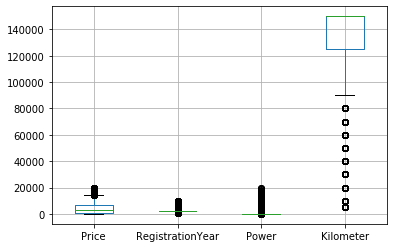

In [7]:
cars_data.boxplot()

Пробег и цену трогать не будем - здесь значения могут быть самыми разными. А вот выбросы в столбцах `RegistrationYear` и `Power` интересны - например, мощностью больше 1000 лошадиных сил могут похвастаться только спротивные автомобили, а год регистрации не может быть больше 2020 и меньше 1931, когда был зарегистрирован первый автомобиль.

In [8]:
#допустим, что в датасете все же есть спортивные автомобили
cars_data = cars_data.query('RegistrationYear <= 2020 and RegistrationYear >= 1931 and Power <= 1200')

In [9]:
cars_data.shape

(353828, 10)

# Обучение и анализ моделей

Задействуем технику прямого кодирования, чтобы преобразовать категориальные признаки в численные. 

In [10]:
cars_data_ohe = pd.get_dummies(cars_data, drop_first=True)

Подготовим признаки и целевой признак, а затем разделим данные на обучающую и тестовую выборки.

In [11]:
#признаки для обучения модели линейной регрессии
features_lr = cars_data_ohe.drop(['Price'], axis = 1)
target_lr = cars_data_ohe['Price']

Преобразуем столбцы с категориальными признаки в тип данных *category*

In [12]:
categorical = ['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Brand', 'NotRepaired']

In [13]:
for col in categorical:
    cars_data[col] = cars_data[col].astype('category')

In [14]:
#признаки для обучения моделей CBR и LGBM
features = cars_data.drop(['Price'], axis = 1)
target = cars_data['Price']

In [15]:
features_train_lr, features_test_lr, target_train_lr, target_test_lr = train_test_split(features_lr, target_lr, test_size=.25, random_state=12345)

In [16]:
features_train, features_test, target_train, target_test = train_test_split(features, target, test_size=.25, random_state=12345)

In [17]:
#напишем формулу для получения значения метрики RMSE
def rmse (target, predictions):
    mse = mean_squared_error(target, predictions)
    rmse = mse ** 0.5
    return rmse

Обучим и проанализируем время работы и качество моделей.

### LinearRegression

In [18]:
lr_model = LinearRegression()

In [19]:
%%time
lr_model.fit(features_train_lr, target_train_lr)

CPU times: user 23.4 s, sys: 9.56 s, total: 33 s
Wall time: 33.2 s


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [36]:
%%time
predicted_lr = pd.Series(lr_model.predict(features_test_lr))

CPU times: user 170 ms, sys: 150 ms, total: 320 ms
Wall time: 273 ms


In [21]:
rmse(target_test_lr, predicted_lr)

2786.7709799955005

### CatBoostRegressor

In [22]:
#построим модель CBR и исследуем её работу с различными значениями гиперпараметра iterations с помощью кросс-валидации
for iteration in range(10, 111, 25):
    cat_model = CatBoostRegressor(loss_function="RMSE", iterations=iteration, depth=10, verbose=10, cat_features=categorical)
    cat_cv = cross_val_score(cat_model, features_train, target_train, cv=2)
    print("Score при iterations =", iteration, ":", cat_cv)
    print("Score mean =", sum(cat_cv)/len(cat_cv))
    print()

0:	learn: 4402.2802324	total: 391ms	remaining: 3.52s
9:	learn: 3706.9180528	total: 3.6s	remaining: 0us
0:	learn: 4431.0023641	total: 313ms	remaining: 2.82s
9:	learn: 3732.5483001	total: 3.39s	remaining: 0us
Score при iterations = 10 : [0.31996929 0.31827532]
Score mean = 0.3191223044585284

0:	learn: 4402.2802324	total: 314ms	remaining: 10.7s
10:	learn: 3642.9599504	total: 3.7s	remaining: 8.08s
20:	learn: 3121.5851039	total: 7s	remaining: 4.67s
30:	learn: 2773.2330590	total: 10.4s	remaining: 1.34s
34:	learn: 2663.9384032	total: 11.8s	remaining: 0us
0:	learn: 4431.0023641	total: 392ms	remaining: 13.3s
10:	learn: 3668.0902962	total: 3.79s	remaining: 8.27s
20:	learn: 3144.0813061	total: 7.18s	remaining: 4.79s
30:	learn: 2789.9046888	total: 10.6s	remaining: 1.36s
34:	learn: 2680.6278170	total: 12.1s	remaining: 0us
Score при iterations = 35 : [0.64837818 0.64660727]
Score mean = 0.647492725934678

0:	learn: 4402.2802324	total: 285ms	remaining: 16.8s
10:	learn: 3642.9599504	total: 3.87s	rema

In [23]:
#исследуем работу модели с различными значениями гиперпараметра depth
for depth in range(5, 16, 2):
    cat_model = CatBoostRegressor(loss_function="RMSE", iterations=20, depth=depth, verbose=10, cat_features=categorical)
    cat_cv = cross_val_score(cat_model, features_train, target_train, cv=2)
    print("Score при depth =", depth, ":", cat_cv)
    print("Score mean =", sum(cat_cv)/len(cat_cv))
    print()

0:	learn: 4416.5875559	total: 123ms	remaining: 2.33s
10:	learn: 3752.7601409	total: 2.13s	remaining: 1.74s
19:	learn: 3328.6877762	total: 3.92s	remaining: 0us
0:	learn: 4444.2379532	total: 123ms	remaining: 2.33s
10:	learn: 3776.3090329	total: 2.03s	remaining: 1.66s
19:	learn: 3340.6146409	total: 3.81s	remaining: 0us
Score при depth = 5 : [0.45251544 0.45299916]
Score mean = 0.45275730031755945

0:	learn: 4406.9675553	total: 196ms	remaining: 3.73s
10:	learn: 3689.1461891	total: 2.89s	remaining: 2.37s
19:	learn: 3240.4432253	total: 5.27s	remaining: 0us
0:	learn: 4436.3507930	total: 214ms	remaining: 4.07s
10:	learn: 3711.3209714	total: 2.89s	remaining: 2.37s
19:	learn: 3256.6330508	total: 5.19s	remaining: 0us
Score при depth = 7 : [0.48138363 0.48038876]
Score mean = 0.48088619631565255

0:	learn: 4403.7050902	total: 300ms	remaining: 5.71s
10:	learn: 3657.2681588	total: 3.69s	remaining: 3.02s
19:	learn: 3189.7753034	total: 6.68s	remaining: 0us
0:	learn: 4432.5990579	total: 238ms	remaining

Можно отметить, что при увеличении iterations модель сначала дает намного бОльшую точность (в 2 раза), затем увеличение точности начинает снижаться, до тех пор, пока разница не становится совсем незначительной. Нужно помнить, что скорость обучения модели для нас важна так же, как и точность ее работы, поэтому не будем жертвовать скоростью и выберем оптимальный вариант с числом iterations 85.

При изменении параметра depth прослеживается такая же тенденция, поэтому оптимальной глубиной будет число 13.

Измерим время обучения и работы модели со значением iterations = 90 и depth = 11.

In [24]:
cat_model_90_11= CatBoostRegressor(loss_function="RMSE", iterations=90, depth=11, verbose=10)

In [25]:
%%time
cat_model_90_11.fit(features_train, target_train, cat_features=categorical)

0:	learn: 4414.1443522	total: 688ms	remaining: 1m 1s
10:	learn: 3640.2660736	total: 7.58s	remaining: 54.5s
20:	learn: 3113.1019108	total: 14.4s	remaining: 47.2s
30:	learn: 2757.6064213	total: 21.1s	remaining: 40.1s
40:	learn: 2507.5453846	total: 27.7s	remaining: 33.2s
50:	learn: 2322.1284447	total: 34.3s	remaining: 26.3s
60:	learn: 2195.6551522	total: 41.1s	remaining: 19.6s
70:	learn: 2104.5056862	total: 47.7s	remaining: 12.8s
80:	learn: 2038.8988468	total: 54.4s	remaining: 6.04s
89:	learn: 1990.5771005	total: 1m	remaining: 0us
CPU times: user 56 s, sys: 5.58 s, total: 1min 1s
Wall time: 1min 2s


In [26]:
%%time
predicted_cat_90_11 = pd.Series(cat_model_90_11.predict(features_test))

CPU times: user 282 ms, sys: 10.4 ms, total: 292 ms
Wall time: 244 ms


In [27]:
rmse(target_test, predicted_cat_90_11)

1993.2263874940566

### LightGBM

In [28]:
params = {
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': 'rmse',
    'max_depth': 6, 
    'learning_rate': 0.1,
    'verbose': 0
}

In [29]:
lgbm_model = LGBMRegressor(**params)

In [30]:
%%time
lgbm_model.fit(features_train, target_train)

CPU times: user 3min 19s, sys: 490 ms, total: 3min 19s
Wall time: 3min 21s


LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.1, max_depth=6,
              metric='rmse', min_child_samples=20, min_child_weight=0.001,
              min_split_gain=0.0, n_estimators=100, n_jobs=-1, num_leaves=31,
              objective='regression', random_state=None, reg_alpha=0.0,
              reg_lambda=0.0, silent=True, subsample=1.0,
              subsample_for_bin=200000, subsample_freq=0, verbose=0)

In [31]:
%%time
predictions_lgbm = lgbm_model.predict(features_test)

CPU times: user 1.24 s, sys: 0 ns, total: 1.24 s
Wall time: 1.22 s


In [32]:
rmse(target_test, predictions_lgbm)

1772.6379449873602

## Вывод

Сравним результаты.

In [37]:
models = [['LR', 33.2, 273, 2787], ['CBR', 62, 244, 1993], 
       ['LGB', 3*60+21, 1.22*1000, 1773]] 
    
df = pd.DataFrame(models, columns =['model', 'train_time, sec', 'work_time, msec', 'rmse']) 
df 

,model,"train_time, sec","work_time, msec",rmse
0,LR,33.2,273.0,2787
1,CBR,62.0,244.0,1993
2,LGB,201.0,1220.0,1773


Время предсказания любой модели значительно меньше, чем её обучение. 
Важно, чтобы время предсказания было как можно меньше - обучаем модель мы только один раз, но предсказывать она может до бесконечности.

Метрика RMSE лучше всего выглядит у модели LGB, но время ее работы слишком долгое. Быстрее всего обучается модель линейной регресии, но ее точность оставляет желать лучшего. У модели CatBoostRegressor небольшое время обучения/работы и приемлемая точность. Эту модель можно посоветовать сервису как прототип.